# Data Prep Guide

To take advantage of Bento's analysis capabilities, we need to provide three layers of information acquired from **molecule-resolved** spatial transcriptomics experiments. At a high level these include:

1. **Molecular coordinates**: The `x` and `y` coordinates for individual transcripts, as well as gene identifiers.
2. **Cell boundaries**: This allows us to assign transcripts to cells. These are usually derived from cell staining i.e. WGA, cell surface markers, polyA stains, nuclear expansion etc.
3. **Nucleus boundaries**: Nuclei are essential for providing subcellular context in our spatial analysis. These are usually derived from DAPI staining or other nuclear markers.

This table shows how the layers of data are used across Bento’s set of analysis tools.

|  | Shape Features | Point Features | RNAflux | RNAforest | RNAcoloc |
| --- | --- | --- | --- | --- | --- |
| Molecular coordinates | No | Yes | Yes | Yes | Yes |
| Cell boundaries | Yes | Yes | Yes | Yes | Yes |
| Nucleus boundaries | Optional | Optional | No | Yes | Optional |

## Using SpatialData

Under the hood, we use the [SpatialData](https://spatialdata.scverse.org/en/latest/) framework to manage `SpatialData` objects in Python, allowing us to store and manipulate spatial data in a standardized format. Briefly, `SpatialData` objects are stored on-disk in the Zarr storage format. We aim to be fully compatible with SpatialData, so you can use the same objects in both Bento and SpatialData.

The `SpatialData` Python object is a flexible container for a variety of elements. For an in-depth look data elements, see this [SpatialData tutorial on SpatialElements](https://spatialdata.scverse.org/en/latest/tutorials/notebooks/notebooks/examples/models2.html). Briefly, they are:

- `Images`: raw images, segmented images
- `Labels`: cell masks, nucleus masks
- `Points`: transcript coordinates, cell coordinates, landmarks
- `Shapes`: boundaries, circles, polygons
- `Tables`: annotations, count matrices

For the purposes of Bento, we will represent data as `Points` (molecules) and `Shapes` (cell & nuclear boundaries). Gene expression is automatically calculated from spatially aggregating transcript counts by shapes and saved as a `Table`.

## Platform-specific data

Steps to ingest your data will depend on how it was generated. Data from some platforms should work out of the box while others will require some more custom formatting.

1. CosMx, Xenium: use the corresponding [spatialdata-io reader functions](https://spatialdata.scverse.org/projects/io/en/latest/api.html).
    1. This will have all three layers of info (molecules, cell boundaries, nuclear boundaries).
2. Merscope: use the corresponding [spatialdata-io reader functions](https://spatialdata.scverse.org/projects/io/en/latest/api.html).
    1. This will only have molecules and cell boundary information.
3. Other platforms: Molecular Cartography, seqFISH, STARmap, home-built MERFISH, smFISH etc.
    1. We will cover how to do this in the next section. For a comprehensive tutorial, see their [detailed guide on constructing your own SpatialData](https://spatialdata.scverse.org/en/latest/tutorials/notebooks/notebooks/examples/models1.html#construct-a-spatialdata-object-from-scratch).

## Loading custom data

Here we will walk through formatting staining images and transcript coordinates into a `SpatialData` object.

```{note}
This guide is a simple demonstration and is **not meant** to be comprehensive. Steps will vary depending on output format and platform.
```

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spatialdata as sd
from cellpose import models
from shapely.geometry import Polygon
from skimage.io import imread
from skimage.measure import find_contours
from spatialdata.models import PointsModel, ShapesModel

### Cell segmentation data

Using a sample image from the Cellpose website, we will demonstrate transforming an image into a set of polygons. 

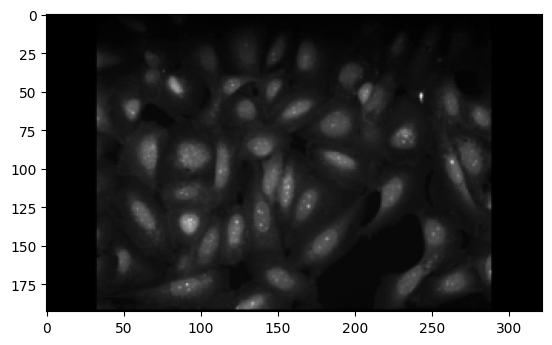

In [5]:
img = imread(
    "https://github.com/ckmah/bento-tools/raw/master/bento/datasets/tutorial/cell_stain.tif"
)
plt.imshow(img, "binary_r")

Load the Cellpose model and segment the image. Each cell is encoded as a separate integer in the mask.

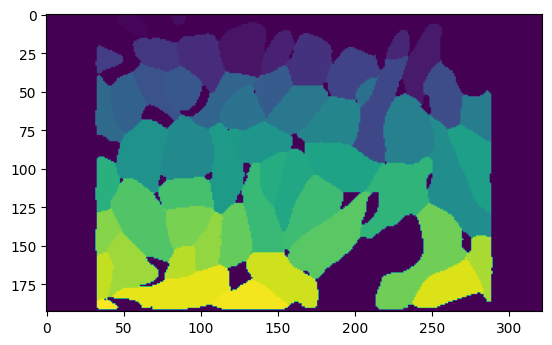

In [6]:
cell_model = models.Cellpose(model_type="cyto3")
cell_mask, _, _, _ = cell_model.eval(img, channels=[[0, 0]])
plt.imshow(cell_mask)

Convert the mask to a set of polygons using `skimage.measure.find_contours`. Each polygon represents a cell boundary.

```{note}
As we do below, note that SpatialData requires the polygons to be stored in a GeoPandas GeoDataFrame.
```

In [26]:
contours = []
for i in range(1, cell_mask.max()):
    contours.append(find_contours(cell_mask == i, 0.5)[0])

cell_polygons = np.array([Polygon(p[:, [1, 0]]) for p in contours])
cell_polygons = gpd.GeoDataFrame(geometry=cell_polygons)
cell_polygons.head()

,geometry
0,"POLYGON ((64.000 14.500, 63.000 14.500, 62.000..."
1,"POLYGON ((86.000 7.500, 85.000 7.500, 84.500 7..."
2,"POLYGON ((137.000 41.500, 136.000 41.500, 135...."
3,"POLYGON ((244.000 58.500, 243.000 58.500, 242...."
4,"POLYGON ((142.000 39.500, 141.000 39.500, 140...."


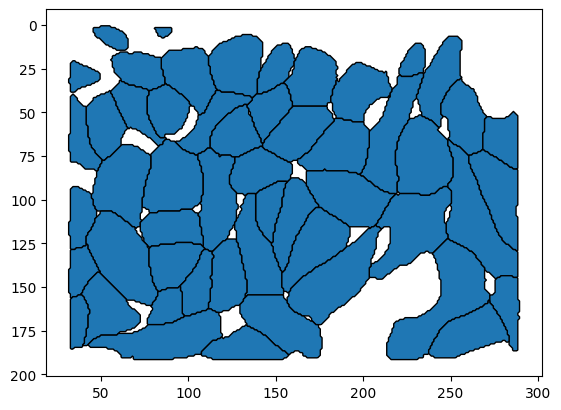

In [28]:
cell_polygons.plot(edgecolor="black")
plt.gca().invert_yaxis()

### Nuclear segmentation data

Nuclear segmentation data can be obtained in a similar way to cell segmentation data. We repeat the same steps as above to obtain a set of polygons representing nuclear boundaries.

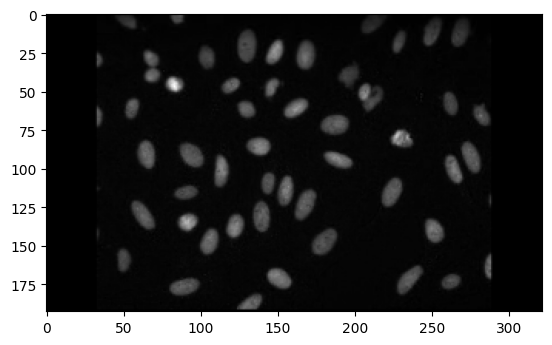

In [29]:
img2 = imread("https://github.com/ckmah/bento-tools/raw/master/bento/datasets/tutorial/nuclear_stain.tif")
plt.imshow(img2, "binary_r")

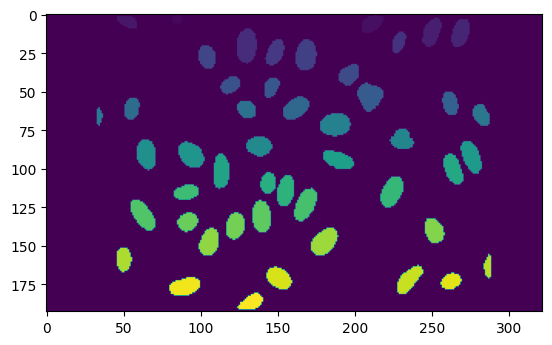

In [30]:
nuclei_model = models.Cellpose(model_type="nuclei")
nuclei_mask, _, _, _ = nuclei_model.eval(img2, channels=[[0, 0]])
plt.imshow(nuclei_mask)

In [31]:
n_contours = []
for i in range(1, nuclei_mask.max()):
    n_contours.append(find_contours(nuclei_mask == i, 0.5)[0])

nuclei_polygons = np.array([Polygon(p[:, [1, 0]]) for p in n_contours])
nuclei_polygons = gpd.GeoDataFrame(geometry=nuclei_polygons)
nuclei_polygons.head()

,geometry
0,"POLYGON ((86.500 0.000, 87.000 0.500, 87.500 1..."
1,"POLYGON ((210.000 12.500, 209.000 12.500, 208...."
2,"POLYGON ((58.000 9.500, 57.000 9.500, 56.000 9..."
3,"POLYGON ((249.000 21.500, 248.000 21.500, 247...."
4,"POLYGON ((268.000 21.500, 267.000 21.500, 266...."


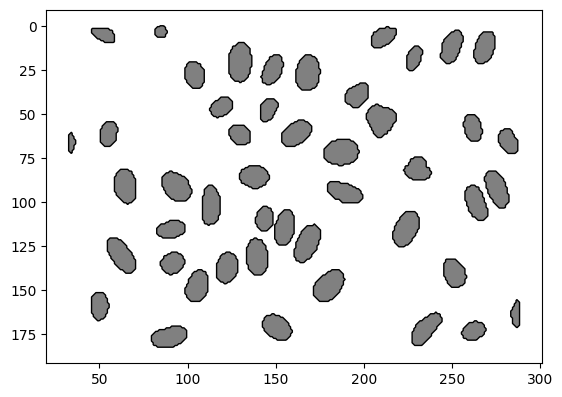

In [32]:
nuclei_polygons.plot(facecolor="grey", edgecolor="black")
plt.gca().invert_yaxis()

### Molecule data
For now, we will generate random transcript coordinates to demonstrate how to format them into a `SpatialData` object.

```{note}
In practice, your transcript coordinates need columns for x, y, and gene. We will name them `x`, `y`, and `feature_name` respectively.
```

In [33]:
p_x = np.random.randint(0, 300, size=10000)
p_y = np.random.randint(0, 200, size=10000)
molecules = pd.DataFrame(dict(x=p_x, y=p_y))
molecules["feature_name"] = np.random.choice(["MALAT1", "ACTB", "BRCA1"], size=10000)
molecules.head()

,x,y,feature_name
0,209,154,MALAT1
1,33,178,MALAT1
2,264,11,BRCA1
3,299,31,ACTB
4,101,82,ACTB


Plot the cell and nuclear boundaries, and the transcript coordinates to ensure they are correctly formatted.

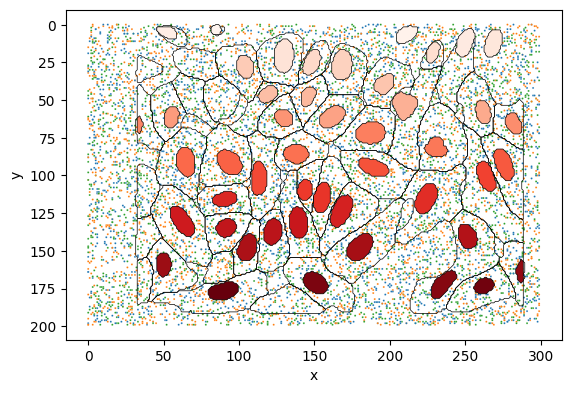

In [35]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=molecules, x="x", y="y", hue="feature_name", ax=ax, s=2, legend=False
)
cell_polygons.plot(ax=ax, facecolor="none", edgecolor="black", lw=0.5)
nuclei_polygons.reset_index().plot(
    ax=ax, column="index", edgecolor="black", cmap="Reds", lw=0.5
)
plt.gca().invert_yaxis()

### Save SpatialData object

Finally, we will save the data as a `SpatialData` object. We use each element type's `parse()` method to guarantee that we have formatted the data correctly.

```{note}
The `SpatialData` object is saved in the Zarr format. This is a compressed, high-performance storage format that is compatible with SpatialData and Bento. When using Bento, you must run `bt.io.prep()` after loading the `SpatialData` object to ensure compatibility.
```

In [36]:
shapes = dict(
    cell_boundaries=ShapesModel.parse(cell_polygons),
    nucleus_boundaries=ShapesModel.parse(nuclei_polygons),
)
points = dict(
    transcripts=PointsModel.parse(
        molecules, coordinates={"x": "x", "y": "y"}, feature_key="feature_name"
    )
)
sdata = sd.SpatialData(
    shapes=shapes,
    points=points,
)

sdata

SpatialData object with:
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 3) (2D points)
└── Shapes
      ├── 'cell_boundaries': GeoDataFrame shape: (54, 1) (2D shapes)
      └── 'nucleus_boundaries': GeoDataFrame shape: (47, 1) (2D shapes)
with coordinate systems:
▸ 'global', with elements:
        transcripts (Points), cell_boundaries (Shapes), nucleus_boundaries (Shapes)

Save to disk.

In [ ]:
sdata.write("tutorial.zarr")

### `prep()` for Bento compatibility

Always run `bt.io.prep()` on `SpatialData` objects for compatibility with Bento.

In [38]:
%load_ext autoreload
%autoreload 2
import bento as bt

bt.io.prep(sdata)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/3 [00:00<?, ?it/s]

SpatialData object with:
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 5) (2D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (54, 3) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (47, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 54 × 3
    obs: 'cell_boundaries', 'region'
    uns: 'spatialdata_attrs': AnnData (54, 3)
with coordinate systems:
▸ 'global', with elements:
        transcripts (Points), cell_boundaries (Shapes), nucleus_boundaries (Shapes)